# Stoneburner, Kurt
- ## DSC 650 - Assignment07


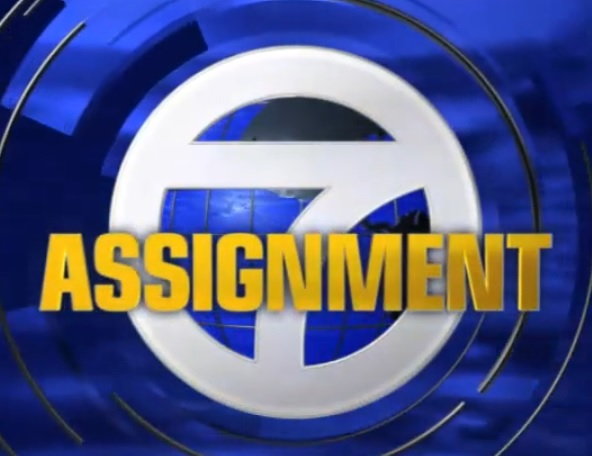


**Apache Parquet**
Gzip Reference:
https://docs.python.org/3/library/gzip.html

Apache Parquet Load from JSONL files
https://arrow.apache.org/docs/python/json.html

Apache Parquet, Read/Write parquet tables
https://arrow.apache.org/docs/python/parquet.html

Python Check if File Exists:
https://www.pythontutorial.net/python-basics/python-check-if-file-exists/



In [1]:
import os
import sys
# //*** Imports and Load Data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

import hashlib
import pygeohash

#//*** Use the whole window in the IPYNB editor
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#//*** Maximize columns and rows displayed by pandas
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

import pyarrow as pa
#from pyarrow.json import read_json
import pyarrow.parquet as pq



#//*** Build results and results/kv folders
current_dir = Path(os.getcwd()).absolute()
results_dir = current_dir.joinpath('results')
kv_dir = results_dir.joinpath('kv')
hash_dir = results_dir.joinpath('hash')
geo_dir  = results_dir.joinpath('geo')

results_dir.mkdir(parents=True, exist_ok=True)
kv_dir.mkdir(parents=True, exist_ok=True)
hash_dir.mkdir(parents=True, exist_ok=True)
geo_dir.mkdir(parents=True, exist_ok=True)



# 7a #
Load Parquet File. Build a Key column Formatted as [dst_Airport]['iata'][src_Airport]['iata'][airline]['icao'].

Create kv_key column, that assigns a value from Partitions. This indexes by 16 values in the partitions table.

Export Parquet storing each kv_key selection as it's own directory.

In [2]:
#//*** Load Parquet file into a Pandas Dataframe
df = pd.read_parquet("routes.parquet")

#//*** Partition index based on first letter of IATA (3 letter airport code)
partitions = (
        ('A', 'A'), ('B', 'B'), ('C', 'D'), ('E', 'F'),
        ('G', 'H'), ('I', 'J'), ('K', 'L'), ('M', 'M'),
        ('N', 'N'), ('O', 'P'), ('Q', 'R'), ('S', 'T'),
        ('U', 'U'), ('V', 'V'), ('W', 'X'), ('Y', 'Z')
    )

#//*** Returns the partition value based on the first letter of the iata field
def get_partition_key(val):

    #//*** Each entry is a dictionary. Get the first letter of the iata value
    letter = val[0] 

    #//*** Loop through the Partitions to find letter value
    #//*** (loople = Loop + Tuple)
    for loople in partitions:
        #//*** If Letter is found in either Tuple Value
        if  letter == loople[0] or letter == loople[1]:
            #//*** If both Tuple entries are the same, return the first tuple
            if loople[0] == loople[1]:
                return loople[0]
            else:
                #//*** Return both formatted tuples as a key
                return f"{loople[0]}-{loople[1]}"


    
print("Length Before:",len(df))

#//*** remove Fields with Empty Airports and airlines
for col in ['src_airport','dst_airport','airline']:
    
    df['empty'] = df[col].apply(lambda x: type(x))

    df = df[df['empty'] != type(None)]
    print(col,len(df))

if 'empty' in df.columns:
    del df['empty']

print("Length After:",len(df))

#//*** Build Key by extracting and combining values from airports and airlines.
df['key'] = df['src_airport'].apply(lambda x: x['iata'])
df['key'] += df['dst_airport'].apply(lambda x: x['iata'])
df['key'] += df['airline'].apply(lambda x: x['icao'])


df['kv_key'] = df['key'].apply(get_partition_key)

#//*** Double check we only only the partition values.
print(df['kv_key'].unique())

#//*** Write everything to disk using parquet partitions
df.to_parquet(str(kv_dir), partition_cols=['kv_key'])

df



Length Before: 67663
src_airport 67180
dst_airport 66771
airline 66771
Length After: 66771
['A' 'C-D' 'E-F' 'G-H' 'K-L' 'M' 'N' 'O-P' 'S-T' 'U' 'B' 'I-J' 'Y-Z' 'Q-R'
 'V' 'W-X']


,airline,src_airport,dst_airport,codeshare,equipment,key,kv_key
0,"{'airline_id': 410, 'name': 'Aerocondor', 'ali...","{'airport_id': 2965.0, 'name': 'Sochi Internat...","{'airport_id': 2990.0, 'name': 'Kazan Internat...",False,[CR2],AERKZNARD,A
1,"{'airline_id': 410, 'name': 'Aerocondor', 'ali...","{'airport_id': 2966.0, 'name': 'Astrakhan Airp...","{'airport_id': 2990.0, 'name': 'Kazan Internat...",False,[CR2],ASFKZNARD,A
2,"{'airline_id': 410, 'name': 'Aerocondor', 'ali...","{'airport_id': 2966.0, 'name': 'Astrakhan Airp...","{'airport_id': 2962.0, 'name': 'Mineralnyye Vo...",False,[CR2],ASFMRVARD,A
3,"{'airline_id': 410, 'name': 'Aerocondor', 'ali...","{'airport_id': 2968.0, 'name': 'Chelyabinsk Ba...","{'airport_id': 2990.0, 'name': 'Kazan Internat...",False,[CR2],CEKKZNARD,C-D
4,"{'airline_id': 410, 'name': 'Aerocondor', 'ali...","{'airport_id': 2968.0, 'name': 'Chelyabinsk Ba...","{'airport_id': 4078.0, 'name': 'Tolmachevo Air...",False,[CR2],CEKOVBARD,C-D
...,...,...,...,...,...,...,...
67658,"{'airline_id': 4178, 'name': 'Regional Express...","{'airport_id': 6334.0, 'name': 'Whyalla Airpor...","{'airport_id': 3341.0, 'name': 'Adelaide Inter...",False,[SF3],WYAADLRXA,W-X
67659,"{'airline_id': 19016, 'name': 'Apache Air', 'a...","{'airport_id': 4029.0, 'name': 'Domodedovo Int...","{'airport_id': 2912.0, 'name': 'Manas Internat...",False,[734],DMEFRUIWA,C-D
67660,"{'airline_id': 19016, 'name': 'Apache Air', 'a...","{'airport_id': 2912.0, 'name': 'Manas Internat...","{'airport_id': 4029.0, 'name': 'Domodedovo Int...",False,[734],FRUDMEIWA,E-F
67661,"{'airline_id': 19016, 'name': 'Apache Air', 'a...","{'airport_id': 2912.0, 'name': 'Manas Internat...","{'airport_id': 2913.0, 'name': 'Osh Airport', ...",False,[734],FRUOSSIWA,E-F


# 7b #

Hash the key column. Create hash_key column using the first character of the hash value

In [3]:
def hash_key(key):
    m = hashlib.sha256()
    m.update(str(key).encode('utf-8'))
    return m.hexdigest()

#//*** Hash the Key Values
df['hashed'] = df['key'].apply(hash_key)

#//*** Get the first character of the hash.
df['hash_key'] = df['hashed'].apply(lambda x: x[0])

df.to_parquet(str(hash_dir), partition_cols=['hash_key'])

df



,airline,src_airport,dst_airport,codeshare,equipment,key,kv_key,hashed,hash_key
0,"{'airline_id': 410, 'name': 'Aerocondor', 'ali...","{'airport_id': 2965.0, 'name': 'Sochi Internat...","{'airport_id': 2990.0, 'name': 'Kazan Internat...",False,[CR2],AERKZNARD,A,aba8e675ed69dc08c83216c16223c87e7269e7a28a610d...,a
1,"{'airline_id': 410, 'name': 'Aerocondor', 'ali...","{'airport_id': 2966.0, 'name': 'Astrakhan Airp...","{'airport_id': 2990.0, 'name': 'Kazan Internat...",False,[CR2],ASFKZNARD,A,2b6ed0aa93298bb2ff79f07a4a7ca145ad8aab1fc62123...,2
2,"{'airline_id': 410, 'name': 'Aerocondor', 'ali...","{'airport_id': 2966.0, 'name': 'Astrakhan Airp...","{'airport_id': 2962.0, 'name': 'Mineralnyye Vo...",False,[CR2],ASFMRVARD,A,749ae10a1b09952ee8c123e6b479054941e4aaa64b3edc...,7
3,"{'airline_id': 410, 'name': 'Aerocondor', 'ali...","{'airport_id': 2968.0, 'name': 'Chelyabinsk Ba...","{'airport_id': 2990.0, 'name': 'Kazan Internat...",False,[CR2],CEKKZNARD,C-D,14c51782ae565b75b98cdf6e2a44ee74751a7a39fd1536...,1
4,"{'airline_id': 410, 'name': 'Aerocondor', 'ali...","{'airport_id': 2968.0, 'name': 'Chelyabinsk Ba...","{'airport_id': 4078.0, 'name': 'Tolmachevo Air...",False,[CR2],CEKOVBARD,C-D,8cd2fe063f2bb82991dbc3655aefa321e7063b61f02a23...,8
...,...,...,...,...,...,...,...,...,...
67658,"{'airline_id': 4178, 'name': 'Regional Express...","{'airport_id': 6334.0, 'name': 'Whyalla Airpor...","{'airport_id': 3341.0, 'name': 'Adelaide Inter...",False,[SF3],WYAADLRXA,W-X,19d63a8b9d9253fdcfcaf42483789254a6c57a8823bc35...,1
67659,"{'airline_id': 19016, 'name': 'Apache Air', 'a...","{'airport_id': 4029.0, 'name': 'Domodedovo Int...","{'airport_id': 2912.0, 'name': 'Manas Internat...",False,[734],DMEFRUIWA,C-D,a4eb6dc575bab967025cc4124fa0026b7d7115807d2103...,a
67660,"{'airline_id': 19016, 'name': 'Apache Air', 'a...","{'airport_id': 2912.0, 'name': 'Manas Internat...","{'airport_id': 4029.0, 'name': 'Domodedovo Int...",False,[734],FRUDMEIWA,E-F,ff7165f6a0af3d54e01f1a7041a1779b698f23966384cf...,f
67661,"{'airline_id': 19016, 'name': 'Apache Air', 'a...","{'airport_id': 2912.0, 'name': 'Manas Internat...","{'airport_id': 2913.0, 'name': 'Osh Airport', ...",False,[734],FRUOSSIWA,E-F,01e90aefc69b71348ef8216c86f78321e446a1287af3df...,0


# 7c #

Assign a geographic location based on longitude. Identify the closest (ish) src_airport to 3 fixed points. Since we are using 3 fixed points. Since these points are located in the United States and the airports are global, measuring distance in a single dimension feels appropriate especially with a wide variance in distance across the data.

The earth is divided into zones of equal latitude between the points. Zones areassigned based on latitude. I could also have geohashed each airport and point, then assigned the airport to the point with the smallest distance. Which would account for distance across two dimensions.

In [4]:
#//*** Define Geo Locations by Longitude.

#//*** Calculate the closest middle Longitude between two points.
#//*** This Calculates the boundaries for both sides of the Central Location Boundaries
def boundary_closest(primary,extant):
    return ((extant - primary) / 2) + primary

#//*** Calculate the Furthest middle longitude between two points
#//*** Invert the values by 180 degress, calculate the distance between and split the difference
def boundary_furthest(coord1, coord2):
    #//*** Convert
    if coord1 < 0:
        coord1_inverse = coord1 + 180
    else:
        coord1_inverse = coord1 - 180
    if coord2 < 0:
        coord2_inverse = coord2 + 180
    else:
        coord2_inverse = coord2 - 180
        
    return ((coord2_inverse - coord1_inverse) / 2) + coord1_inverse

longitude_ref = {
    "west" : -121.1786823,
    "central" : -96.0422378,
    "east" : -77.6497145
}

#//*** The central boundary is split evenly between the west and east boundaries.
#//*** The west and east boundaries extend from the central boundary, to an equal portion of the opposite end of the earth
#//***
boundaries = {
    "west" : (
        boundary_closest(longitude_ref['central'],longitude_ref['west']),
        boundary_furthest(longitude_ref['west'],longitude_ref['east'])
    ),
    "central" : (
        boundary_closest(longitude_ref['central'],longitude_ref['west']),
        boundary_closest(longitude_ref['central'],longitude_ref['east'])
    ),
    "east" : (
        boundary_closest(longitude_ref['central'],longitude_ref['east']),
        boundary_furthest(longitude_ref['west'],longitude_ref['east'])
    )
}

def get_closest_location(input_val):
    
    #//*** Withing the Bound of central, then it's central
    col = 'central'
    if boundaries[col][0] < input_val['longitude']  < boundaries[col][1]:
        #print(f"{boundaries[col][0]} < {input_val['longitude']} < {boundaries[col][1]} ") 
        return col

    
    if input_val['longitude'] < 0:
        
        if input_val['longitude'] < boundaries['west'][0]:
            return "west"
        
        else:
            return "east"

        
    else:
        
        if input_val['longitude'] < boundaries['west'][1]:
            return "west"
        else:
            return "east"


df['location'] = df['src_airport'].apply(get_closest_location)
df['longitude'] = df['src_airport'].apply(lambda x:x['longitude'])

#//*** Double check our work, getting spaces within longitude values was more nuanced than expected
for group in df.groupby('location'):
    print(group[0], "Count: ", len(group[1]), " Boundaries - ",boundaries[group[0]], "Min: ",group[1]['longitude'].min(),"- Max: ", group[1]['longitude'].max())
    #print(group[1][['longitude','location']])
    #print(group['src_airport'].apply(lambda x:x['longitude']))
del df['longitude']
df.to_parquet(str(geo_dir), partition_cols=['location'])



central Count:  4904  Boundaries -  (-108.61046005, -86.84597615) Min:  -108.54299926757812 - Max:  -86.852997
east Count:  34507  Boundaries -  (-86.84597615, 80.5858016) Min:  -86.775100708008 - Max:  179.34100341799999
west Count:  27360  Boundaries -  (-108.61046005, 80.5858016) Min:  -179.87699890099998 - Max:  80.58190155029297


In [5]:
# Assignment 7.1.c
df['src_airport_geohash'] = df.apply(
    lambda row: pygeohash.encode(row['src_airport']['latitude'], row['src_airport']['longitude']), axis=1
)
def determine_location(src_airport_geohash):
    locations = dict(
        central=pygeohash.encode(41.1544433, -96.0422378),
        west = pygeohash.encode( 45.5945645, -121.1786823),
        east = pygeohash.encode( 39.08344, -77.6497145),
        ## TODO: add west and east
    )
    
    #//*** Generate a 
    distances = [
        (pygeohash.geohash_haversine_distance(src_airport_geohash,locations['central']),"central"),
        (pygeohash.geohash_haversine_distance(src_airport_geohash,locations['west']),"west"),
        (pygeohash.geohash_haversine_distance(src_airport_geohash,locations['east']),"east"),
    ]
    distances.sort()
    
    return distances[0][1]
df['geo_location'] = df['src_airport_geohash'].apply(determine_location)
#df.to_parquet('results/geo', partition_cols=['location'])

In [6]:
df

,airline,src_airport,dst_airport,codeshare,equipment,key,kv_key,hashed,hash_key,location,src_airport_geohash,geo_location
0,"{'airline_id': 410, 'name': 'Aerocondor', 'ali...","{'airport_id': 2965.0, 'name': 'Sochi Internat...","{'airport_id': 2990.0, 'name': 'Kazan Internat...",False,[CR2],AERKZNARD,A,aba8e675ed69dc08c83216c16223c87e7269e7a28a610d...,a,west,szsrjjzd02b3,east
1,"{'airline_id': 410, 'name': 'Aerocondor', 'ali...","{'airport_id': 2966.0, 'name': 'Astrakhan Airp...","{'airport_id': 2990.0, 'name': 'Kazan Internat...",False,[CR2],ASFKZNARD,A,2b6ed0aa93298bb2ff79f07a4a7ca145ad8aab1fc62123...,2,west,v04pk3t5gbjj,east
2,"{'airline_id': 410, 'name': 'Aerocondor', 'ali...","{'airport_id': 2966.0, 'name': 'Astrakhan Airp...","{'airport_id': 2962.0, 'name': 'Mineralnyye Vo...",False,[CR2],ASFMRVARD,A,749ae10a1b09952ee8c123e6b479054941e4aaa64b3edc...,7,west,v04pk3t5gbjj,east
3,"{'airline_id': 410, 'name': 'Aerocondor', 'ali...","{'airport_id': 2968.0, 'name': 'Chelyabinsk Ba...","{'airport_id': 2990.0, 'name': 'Kazan Internat...",False,[CR2],CEKKZNARD,C-D,14c51782ae565b75b98cdf6e2a44ee74751a7a39fd1536...,1,west,v3gdxs17du83,west
4,"{'airline_id': 410, 'name': 'Aerocondor', 'ali...","{'airport_id': 2968.0, 'name': 'Chelyabinsk Ba...","{'airport_id': 4078.0, 'name': 'Tolmachevo Air...",False,[CR2],CEKOVBARD,C-D,8cd2fe063f2bb82991dbc3655aefa321e7063b61f02a23...,8,west,v3gdxs17du83,west
...,...,...,...,...,...,...,...,...,...,...,...,...
67658,"{'airline_id': 4178, 'name': 'Regional Express...","{'airport_id': 6334.0, 'name': 'Whyalla Airpor...","{'airport_id': 3341.0, 'name': 'Adelaide Inter...",False,[SF3],WYAADLRXA,W-X,19d63a8b9d9253fdcfcaf42483789254a6c57a8823bc35...,1,east,r41gcjy9uwef,west
67659,"{'airline_id': 19016, 'name': 'Apache Air', 'a...","{'airport_id': 4029.0, 'name': 'Domodedovo Int...","{'airport_id': 2912.0, 'name': 'Manas Internat...",False,[734],DMEFRUIWA,C-D,a4eb6dc575bab967025cc4124fa0026b7d7115807d2103...,a,west,ucfgnwfe8u9e,east
67660,"{'airline_id': 19016, 'name': 'Apache Air', 'a...","{'airport_id': 2912.0, 'name': 'Manas Internat...","{'airport_id': 4029.0, 'name': 'Domodedovo Int...",False,[734],FRUDMEIWA,E-F,ff7165f6a0af3d54e01f1a7041a1779b698f23966384cf...,f,west,txsuyz0fjzgd,west
67661,"{'airline_id': 19016, 'name': 'Apache Air', 'a...","{'airport_id': 2912.0, 'name': 'Manas Internat...","{'airport_id': 2913.0, 'name': 'Osh Airport', ...",False,[734],FRUOSSIWA,E-F,01e90aefc69b71348ef8216c86f78321e446a1287af3df...,0,west,txsuyz0fjzgd,west


# 7d #
Split an order list of keys across a variable partitions count.

Partitions should return starting value, ending value, and the list of keys. These properties are stored in a partition_class class.

In [8]:
class partition_class():
    #//*** Format the class data on creation. Assumes data is already sorted
    def __init__(self,keys):
        self.start = keys[0]
        self.end = keys[-1]
        self.keys = list(keys)
    
    def start(self):
        return self.start
    
    def end(self):
        return self.end
    
    def keys(self):
        return self.keys
    
    #//*** Nicely format for display printing
    def __repr__(self):
        out = "\n"
        out += "start index: "
        out += self.start
        out += "\n"
        out += "end index:   "
        out += self.end
        out += "\n"
        out += "keys: "
        out += str(np.array(self.keys))
        out += "\nLength: "
        out += str(len(self.keys))
        out += "\n"      
        
        
        return out
    

    
#//*** Divides a sorted list of keys evenly(ish) across num_partitions
def balance_partitions(keys, num_partitions):
    keys = list(keys)
    
    #//*** Divide the series by num_partitions to get and equal(ish) balance of keys.
    index_multiple = int(len(keys)/num_partitions) 

    partitions = []

    #//*** Build partition Indexes
    #//*** Slice the keys list by index values using the index multiple
    for x in range(num_partitions):
        if x+1 < num_partitions:
            key_list = keys[x*index_multiple:(x+1)*index_multiple]
        else:
            #//*** Last key, grab all values from index to the end
            key_list = keys[x*index_multiple:]
        
        #//*** Build Partition class from key_list.
        #//*** Returns keys, start and End indexes
        partitions.append(partition_class(key_list))
        
    return partitions

#//*** Build a Sorted list of hashed keys
keys = list(np.sort(df['hashed'].unique()))

#//*** Return a list of partition_class partitions
partitions = balance_partitions(keys,3)

print("=============================================")
print("Three Partition Example using hashes for Keys")
print("=============================================")
print(partitions)


print("=========================================")
print("Thirty Partition Example using key values")
print("=========================================")
keys = list(np.sort(df['key'].unique()))
partitions = balance_partitions(keys,30)
print(partitions)



Three Partition Example using hashes for Keys
[
start index: 000224e90d8451281c00829decf16594da6ec6c0082c22500266fa503dc360dd
end index:   550afaa93cc6218ae0f59875e4a976d3730770ce2f27112984cbdcaf6deeba65
keys: ['000224e90d8451281c00829decf16594da6ec6c0082c22500266fa503dc360dd'
 '00037d7d0a03a49f84d8623e5f6ecdcabdafc52f380987ac4f615b4ffe10d510'
 '00054897d2393efa4943eee23957d1478e5c06bb24d0829e79a1819afef9030a' ...
 '5509ed25f3e91e1e763b24f3fbf4109f88074a7b487f078b85888134eba5bc92'
 '550a947fe7e5d9e443e6d49e1769e8cb4d5ea4510b1b2e0341eed50d8c6548e9'
 '550afaa93cc6218ae0f59875e4a976d3730770ce2f27112984cbdcaf6deeba65']
Length: 22246
, 
start index: 550b286629660ccbb3e0058b23c5d897a484021b3f37bf83d522af6b85b8ff11
end index:   aa13e81971aaf74f605428ff6354bc9a37ccdc18435e7a94be7f350296c87991
keys: ['550b286629660ccbb3e0058b23c5d897a484021b3f37bf83d522af6b85b8ff11'
 '550b4f4c812b7aa2c186e97f64700a16ff3dff20e38a553c6d76819f83847200'
 '550b84860c57338d1cc907cbdad3b3a224895149bd269963135d6039dc75